# The Poisson problem with complex numbers

Author: Jørgen S. Dokken

Many PDEs, such as the [Helmholtz equation](https://docs.fenicsproject.org/dolfinx/v0.4.1/python/demos/demo_helmholtz.html) require complex-valued fields.

For simplicity, let us consider a Poisson equation of the form: 

$$-\Delta u = f \text{ in } \Omega,$$
$$ f = -1 - 2j \text{ in }  \Omega,$$
$$ u = u_{exact} \text{ on } \partial\Omega,$$
$$u_{exact}(x, y) = \frac{1}{2}x^2 + 1j\cdot y^2,$$

As in [Solving the Poisson equation](./fundamentals) we want to express our partial differential equation as a weak formulation.

We start by defining our discrete function space $V_h$, such that $u_h\in V_h$ and $u_h = \sum_{i=1}^N c_i \phi_i(x, y)$ where $\phi_i$ are **real valued** global basis functions of our space $V_h$, $c_i \in \mathcal{C}$ are the **complex valued** degrees of freedom.

Next, we choose a test function $v\in \hat V_h$ where $\hat V_h\subset V_h$ such that $v\vert_{\partial\Omega}=0$, as done in the first tutorial. 
We now need to define our inner product space. We choose the $L^2$ inner product spaces, which is a *[sesquilinear](https://en.wikipedia.org/wiki/Sesquilinear_form) 2-form*, Meaning that $\langle u, v\rangle$ is a map from $V_h\times V_h\mapsto K$, and $\langle u, v \rangle = \int_\Omega u \cdot \bar v ~\mathrm{d} x$. As it is sesquilinear, we have the following properties:

$$\langle u , v \rangle = \overline{\langle v, u \rangle},$$
$$\langle u , u \rangle \geq 0.$$

We can now use this inner product space to do integration by parts

$$\int_\Omega \nabla u_h \cdot \nabla \overline{v}~ \mathrm{dx} = \int_{\Omega} f \cdot \overline{v} ~\mathrm{d} s \qquad \forall v \in \hat{V}_h.$$

## Installation of FEniCSx with complex number support
FEniCSx supports both real and complex numbers, meaning that we can create a function spaces with real valued or complex valued coefficients.

In [1]:
import dolfinx
from mpi4py import MPI
import numpy as np
mesh = dolfinx.mesh.create_unit_square(MPI.COMM_WORLD, 10, 10)
V = dolfinx.fem.functionspace(mesh, ("Lagrange", 1))
u_r = dolfinx.fem.Function(V, dtype=np.float64) 
u_r.interpolate(lambda x: x[0])
u_c = dolfinx.fem.Function(V, dtype=np.complex128)
u_c.interpolate(lambda x:0.5*x[0]**2 + 1j*x[1]**2)
print(u_r.x.array.dtype)
print(u_c.x.array.dtype)

float64
complex128


However, as we would like to solve linear algebra problems on the form $Ax=b$, we need to be able to use matrices and vectors that support real and complex numbers. As [PETSc](https://petsc.org/release/) is one of the most popular interfaces to linear algebra packages, we need to be able to work with their matrix and vector structures. 

Unfortunately, PETSc only supports one floating type in their matrices, thus we need to install two versions of PETSc, one that supports `float64` and one that supports `complex128`. In the [docker images](https://hub.docker.com/r/dolfinx/dolfinx) for DOLFINx, both versions are installed, and one can switch between them by calling `source dolfinx-real-mode` or `source dolfinx-complex-mode`. For the `dolfinx/lab` images, one can change the Python kernel to be either the real or complex mode, by going to `Kernel->Change Kernel...` and choose `Python3 (ipykernel)` (for real mode) or `Python3 (DOLFINx complex)` (for complex mode).

We check that we are using the correct installation of PETSc by inspecting the scalar type.

In [2]:
from petsc4py import PETSc
from dolfinx.fem.petsc import assemble_vector
print(PETSc.ScalarType)
assert np.dtype(PETSc.ScalarType).kind == 'c'

<class 'numpy.complex128'>


## Variational problem
We are now ready to define our variational problem

In [3]:
import ufl
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
f = dolfinx.fem.Constant(mesh, PETSc.ScalarType(-1 - 2j))
a = ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = ufl.inner(f, v) * ufl.dx

Note that we have used the `PETSc.ScalarType` to wrap the constant source on the right hand side. This is because we want the integration kernels to assemble into the correct floating type.

Secondly, note that we are using `ufl.inner` to describe multiplication of $f$ and $v$, even if they are scalar values. This is because `ufl.inner` takes the conjugate of the second argument, as decribed by the $L^2$ inner product. One could alternatively write this out manually

### Inner-products and derivatives

In [4]:
L2 = f * ufl.conj(v) * ufl.dx
print(L)
print(L2)

{ c_0 * (conj((v_0))) } * dx(<Mesh #0>[everywhere], {})
{ c_0 * (conj((v_0))) } * dx(<Mesh #0>[everywhere], {})


Similarly, if we want to use the function $ufl.derivative$ to take derivatives of functionals, we need to take some special care. As `derivative` inserts a `ufl.TestFunction` to represent the variation, we need to take the conjugate of this to be able to use it to assemble vectors.

In [5]:
J = u_c**2 * ufl.dx
F = ufl.derivative(J, u_c, ufl.conj(v))
residual = assemble_vector(dolfinx.fem.form(F))
print(residual.array)

[4.21666667e-03+3.33333333e-05j 1.58750000e-03+8.33333333e-06j
 4.68333333e-03+1.00000000e-04j 8.13333333e-03+2.66666667e-04j
 3.35000000e-03+3.33333333e-05j 4.68333333e-03+3.66666667e-04j
 6.43333333e-03+2.66666667e-04j 8.13333333e-03+8.66666667e-04j
 2.58333333e-03+3.33333333e-05j 4.68333333e-03+8.33333333e-04j
 4.93333333e-03+2.66666667e-04j 6.43333333e-03+8.66666667e-04j
 8.13333333e-03+1.86666667e-03j 1.91666667e-03+3.33333333e-05j
 4.68333333e-03+1.50000000e-03j 3.63333333e-03+2.66666667e-04j
 4.93333333e-03+8.66666667e-04j 6.43333333e-03+1.86666667e-03j
 8.13333333e-03+3.26666667e-03j 1.35000000e-03+3.33333333e-05j
 4.68333333e-03+2.36666667e-03j 2.53333333e-03+2.66666667e-04j
 3.63333333e-03+8.66666667e-04j 4.93333333e-03+1.86666667e-03j
 6.43333333e-03+3.26666667e-03j 8.13333333e-03+5.06666667e-03j
 8.83333333e-04+3.33333333e-05j 4.68333333e-03+3.43333333e-03j
 1.63333333e-03+2.66666667e-04j 2.53333333e-03+8.66666667e-04j
 3.63333333e-03+1.86666667e-03j 4.93333333e-03+3.266666

We define our Dirichlet condition and setup and solve the variational problem.
## Solve variational problem

In [6]:
mesh.topology.create_connectivity(mesh.topology.dim-1, mesh.topology.dim)
boundary_facets = dolfinx.mesh.exterior_facet_indices(mesh.topology)
boundary_dofs = dolfinx.fem.locate_dofs_topological(V, mesh.topology.dim-1, boundary_facets)
bc = dolfinx.fem.dirichletbc(u_c, boundary_dofs)
problem = dolfinx.fem.petsc.LinearProblem(a, L, bcs=[bc])
uh = problem.solve()

We compute the $L^2$ error and the max error
## Error computation

In [7]:
x = ufl.SpatialCoordinate(mesh)
u_ex = 0.5 * x[0]**2 + 1j*x[1]**2
L2_error = dolfinx.fem.form(ufl.dot(uh-u_ex, uh-u_ex) * ufl.dx(metadata={"quadrature_degree": 5}))
local_error = dolfinx.fem.assemble_scalar(L2_error)
global_error = np.sqrt(mesh.comm.allreduce(local_error, op=MPI.SUM))
max_error = mesh.comm.allreduce(np.max(np.abs(u_c.x.array-uh.x.array)))
print(global_error, max_error)

(0.0007865435216227239+0.0017660156338113711j) 3.553078358632328e-06


## Plotting
Finally, we plot the real and imaginary solution

In [8]:
import pyvista
pyvista.start_xvfb()
p_mesh = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(mesh, mesh.topology.dim))
pyvista_cells, cell_types, geometry = dolfinx.plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)
grid.point_data["u_real"] = uh.x.array.real
grid.point_data["u_imag"] = uh.x.array.imag
_ = grid.set_active_scalars("u_real")

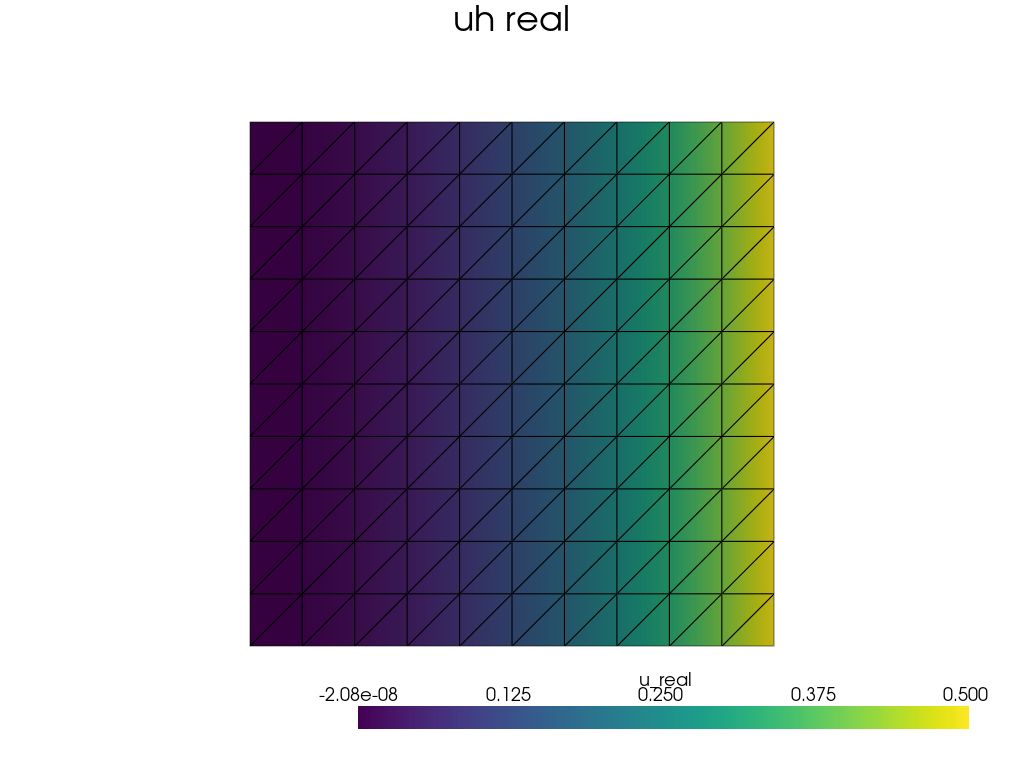

In [9]:
p_real = pyvista.Plotter()
p_real.add_text("uh real", position="upper_edge", font_size=14, color="black")
p_real.add_mesh(grid, show_edges=True)
p_real.view_xy()
if not pyvista.OFF_SCREEN:
    p_real.show()

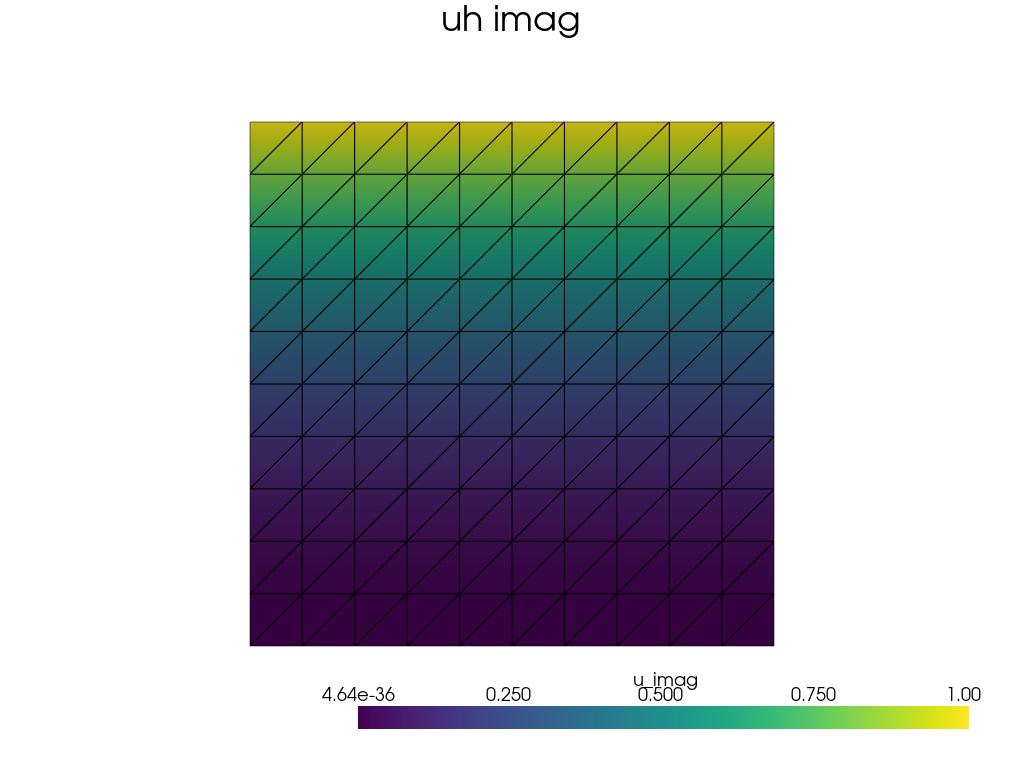

In [10]:
grid.set_active_scalars("u_imag")
p_imag = pyvista.Plotter()
p_imag.add_text("uh imag", position="upper_edge", font_size=14, color="black")
p_imag.add_mesh(grid, show_edges=True)
p_imag.view_xy()
if not pyvista.OFF_SCREEN:
    p_imag.show()